# SageMaker Training Job 訓練 Ultralytics YOLO11（YOLOv11）

此 Notebook 會：
1. 生成訓練程式 `train.py` 與 `requirements.txt`
2. 以 **SageMaker PyTorch Estimator** 啟動 Training Job
3. 在 Notebook 內**串流顯示訓練日誌**，並**嘗試動態解析每個 epoch 指標，畫出收斂曲線**
4. 訓練完成後下載 artifacts（含 `best.pt`、`runs/`、`results.csv`、`results.png`）並顯示完整曲線

> 注意：動態曲線解析依賴 Ultralytics 日誌格式；若版本輸出不同，可能解析不到，但**訓練完成後**一定能用 `results.csv/results.png` 畫出完整收斂曲線。


## 0) 先決條件

- 已在 SageMaker Studio / Notebook Instance 執行
- IAM role 具備 SageMaker 與 S3 權限
- 你已把 YOLO 格式資料集打包成 zip 放在 S3

資料 zip 內部建議結構：
```
mydata/
  images/train
  images/val
  labels/train
  labels/val
```


In [1]:
import os, json, tarfile, re, time
from pathlib import Path

import boto3
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput
from sagemaker.s3 import S3Downloader

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Image

sess = sagemaker.Session()
region = sess.boto_region_name
role = sagemaker.get_execution_role()
sm = boto3.client('sagemaker', region_name=region)
logs = boto3.client('logs', region_name=region)

print('region:', region)
print('default bucket:', sess.default_bucket())


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Matplotlib is building the font cache; this may take a moment.


region: us-east-1
default bucket: sagemaker-us-east-1-049281306005


## 1) 參數設定（請改成你的 S3 路徑與類別名稱）

In [2]:
# ====== 你要改的地方 ======
S3_DATA_ZIP = 's3://2025team7/Fruit.v7i.yolov11.zip'  # <<<<<< 改成你的資料集
DATA_ZIP_FILENAME = 'Fruit.v7i.yolov11.zip'                     # zip 檔名

# 類別名稱（請改成你的 classes）
CLASS_NAMES = ['apple', 'banana', 'grape', 'kiwi', 'lemon', 'orange', 'peach', 'pineapple', 'strawberry', 'watermelon']

# YOLO11 權重（可改 yolo11s.pt / yolo11m.pt / yolo11l.pt / yolo11x.pt）
YOLO_MODEL = 'yolo11n.pt'

# 訓練超參數
EPOCHS = 50
IMGSZ = 640
BATCH = 16
WORKERS = 4

# 訓練硬體（推薦 GPU：g5 / g4dn）
INSTANCE_TYPE = 'ml.g5.2xlarge'
INSTANCE_COUNT = 1

# 輸出到 S3
OUTPUT_S3 = f"s3://2025team7/yolo11/output/"

print('S3_DATA_ZIP:', S3_DATA_ZIP)
print('OUTPUT_S3:', OUTPUT_S3)

print('Classes:', len(CLASS_NAMES), '個水果類別')


S3_DATA_ZIP: s3://2025team7/Fruit.v7i.yolov11.zip
OUTPUT_S3: s3://2025team7/yolo11/output/
Classes: 10 個水果類別


## 2) 生成訓練程式碼（train.py）與 requirements.txt

重點：
- SageMaker 會把 `training` channel 掛載在 `/opt/ml/input/data/training/`
- 你要把 artifacts 寫到 `/opt/ml/model/`，SageMaker 才會上傳到 `output_path`
- 我們把 Ultralytics 的 `runs/` 放到 `/opt/ml/model/runs/`，方便事後下載 `results.csv` / `results.png`


In [10]:
src_dir = Path('src')
src_dir.mkdir(exist_ok=True)

train_py = r'''
import argparse
import base64
import json
import zipfile
import shutil
from pathlib import Path
import yaml
from ultralytics import YOLO

def main():
    p = argparse.ArgumentParser()
    p.add_argument('--data_zip', type=str, default='mydata.zip')
    p.add_argument('--model', type=str, default='yolo11n.pt')
    p.add_argument('--epochs', type=int, default=50)
    p.add_argument('--imgsz', type=int, default=640)
    p.add_argument('--batch', type=int, default=16)
    p.add_argument('--workers', type=int, default=4)

    # ✅ 改成 base64，避免 argv 被拆
    p.add_argument('--class_names_b64', type=str, required=True)

    args = p.parse_args()

    # ✅ 解碼回 list[str]
    class_names = json.loads(base64.b64decode(args.class_names_b64).decode("utf-8"))

    sm_data_dir = Path('/opt/ml/input/data/training')
    sm_model_dir = Path('/opt/ml/model')
    sm_model_dir.mkdir(parents=True, exist_ok=True)

    work_dir = Path('/tmp/data')
    work_dir.mkdir(parents=True, exist_ok=True)

    # ✅ 解壓 zip 檔案
    zip_path = sm_data_dir / args.data_zip
    print(f"📦 Extracting {zip_path} to {work_dir}")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(work_dir)

    # ✅ 尋找 Fruit.v7i.yolov11 資料夾（或任何包含 train/valid 的資料夾）
    dataset_root = None
    for item in work_dir.rglob('*'):
        if item.is_dir():
            # 檢查是否包含 train 和 valid 子資料夾
            if (item / 'train').exists() and (item / 'valid').exists():
                dataset_root = item
                break

    # 如果找不到，嘗試直接使用 work_dir
    if dataset_root is None:
        if (work_dir / 'train').exists() and (work_dir / 'valid').exists():
            dataset_root = work_dir
        else:
            # 列出所有內容以便除錯
            print("❌ Cannot find train/valid folders. Contents of work_dir:")
            for item in work_dir.rglob('*'):
                print(f"  {item}")
            raise FileNotFoundError("Cannot find dataset with train/valid folders")

    print(f"✅ Found dataset root: {dataset_root}")
    print(f"   Train folder: {dataset_root / 'train'}")
    print(f"   Valid folder: {dataset_root / 'valid'}")

    data_yaml = {
        'path': str(dataset_root),
        'train': 'train/images',  # 使用相對路徑
        'val': 'valid/images',    # 使用相對路徑
        'test': 'test/images',    # 使用相對路徑
        'names': class_names,
        'nc': len(class_names),
    }
    yaml_path = work_dir / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.safe_dump(data_yaml, f)

    print(f"✅ Created data.yaml with {len(class_names)} classes")
    print(f"   Path: {data_yaml['path']}")
    print(f"   Train: {data_yaml['train']}")
    print(f"   Val:   {data_yaml['val']}")

    model = YOLO(args.model)
    project_dir = sm_model_dir / 'runs'
    model.train(
        data=str(yaml_path),
        epochs=args.epochs,
        imgsz=args.imgsz,
        batch=args.batch,
        workers=args.workers,
        project=str(project_dir),
        name='train',
        verbose=True,
        patience=50,  # Early stopping patience
        save=True,
        plots=True,
    )

    best_pt = project_dir / 'train' / 'weights' / 'best.pt'
    if best_pt.exists():
        shutil.copy2(best_pt, sm_model_dir / 'best.pt')
        print("✅ Copied best.pt to model dir")

if __name__ == '__main__':
    main()

'''

(src_dir / 'train.py').write_text(train_py, encoding='utf-8')
(src_dir / 'requirements.txt').write_text('ultralytics\nopencv-python\npyyaml\n', encoding='utf-8')
print('Wrote:', src_dir / 'train.py')
print('Wrote:', src_dir / 'requirements.txt')


Wrote: src/train.py
Wrote: src/requirements.txt


## 3) 建立 Estimator 並啟動 Training Job（非阻塞）

In [11]:
import base64, json

class_names_b64 = base64.b64encode(
    json.dumps(CLASS_NAMES, ensure_ascii=False).encode("utf-8")
).decode("ascii")

hyperparameters = {
    "data_zip": DATA_ZIP_FILENAME,
    "model": YOLO_MODEL,
    "epochs": EPOCHS,
    "imgsz": IMGSZ,
    "batch": BATCH,
    "workers": WORKERS,
    "class_names_b64": class_names_b64,
}

est = PyTorch(
    entry_point='train.py',
    source_dir=str(src_dir),
    role=role,
    framework_version='2.2',
    py_version='py310',
    instance_count=INSTANCE_COUNT,
    instance_type=INSTANCE_TYPE,
    hyperparameters=hyperparameters,
    output_path=OUTPUT_S3,
)

job_name = f"yolo11-train-{int(time.time())}"
print('TrainingJobName:', job_name)

est.fit(
    inputs={'training': TrainingInput(S3_DATA_ZIP, content_type='application/zip')},
    job_name=job_name,
    wait=False,
)
print('已送出 Training Job。接著跑下一格開始動態監控。')


INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: yolo11-train-1767602003


TrainingJobName: yolo11-train-1767602003
已送出 Training Job。接著跑下一格開始動態監控。


## 4) 動態顯示訓練過程與收斂曲線（即時）

會從 CloudWatch Logs 拉取最新日誌並嘗試解析 epoch 指標。


In [17]:
import boto3, re

logs = boto3.client("logs", region_name=region)

def list_sagemaker_log_groups(prefix_hint="/aws/sagemaker"):
    resp = logs.describe_log_groups(logGroupNamePrefix=prefix_hint, limit=50)
    return [g["logGroupName"] for g in resp.get("logGroups", [])]

print("\n".join(list_sagemaker_log_groups()))
desc = sm.describe_training_job(TrainingJobName=job_name)
print("TrainingJobArn =", desc["TrainingJobArn"])


/aws/sagemaker/NotebookInstances
/aws/sagemaker/TrainingJobs
TrainingJobArn = arn:aws:sagemaker:us-east-1:049281306005:training-job/yolo11-train-1767602003


In [18]:
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
import boto3
from IPython.display import display, clear_output

# ------------------------------------------------------------
# 1) 先用原本的 sm 取得 TrainingJobArn，反推出 job 的 region
# ------------------------------------------------------------
desc = sm.describe_training_job(TrainingJobName=job_name)
training_job_arn = desc["TrainingJobArn"]
job_region = training_job_arn.split(":")[3]

print("TrainingJobArn:", training_job_arn)
print("Job region    :", job_region)

# ------------------------------------------------------------
# 2) 用「job 的 region」重新建立 clients（關鍵修正點）
# ------------------------------------------------------------
logs = boto3.client("logs", region_name=job_region)
sm2  = boto3.client("sagemaker", region_name=job_region)

print("CloudWatch logs region =", logs.meta.region_name)
print("SageMaker client region =", sm2.meta.region_name)

# ------------------------------------------------------------
# 3) 重新定義 helper functions（只差在用 sm2 / logs）
# ------------------------------------------------------------
def get_training_job_status(job_name: str):
    d = sm2.describe_training_job(TrainingJobName=job_name)
    return d["TrainingJobStatus"], d

def find_log_stream(job_name: str, log_group="/aws/sagemaker/TrainingJobs"):
    paginator = logs.get_paginator("describe_log_streams")
    for page in paginator.paginate(
        logGroupName=log_group,
        logStreamNamePrefix=job_name
    ):
        streams = page.get("logStreams", [])
        if streams:
            streams = sorted(
                streams,
                key=lambda s: s.get("lastEventTimestamp", 0),
                reverse=True
            )
            return streams[0]["logStreamName"]
    return None

def fetch_logs(log_group, log_stream, next_token=None):
    kwargs = dict(
        logGroupName=log_group,
        logStreamName=log_stream,
        startFromHead=True
    )
    if next_token:
        kwargs["nextToken"] = next_token
    resp = logs.get_log_events(**kwargs)
    return resp.get("events", []), resp.get("nextForwardToken")

# ------------------------------------------------------------
# 4) epoch log best-effort parser（不變）
# ------------------------------------------------------------
epoch_metrics = []
epoch_line_re = re.compile(
    r"^\s*(\d+)\s+([0-9.eE+-]+)\s+([0-9.eE+-]+)\s+([0-9.eE+-]+)\s+([0-9.eE+-]+)\s+([0-9.eE+-]+)"
)

def try_parse_epoch_line(msg: str):
    m = epoch_line_re.match(msg)
    if not m:
        return None
    epoch = int(m.group(1))
    vals = [float(m.group(i)) for i in range(2, 7)]
    return {
        "epoch": epoch,
        "v1": vals[0],
        "v2": vals[1],
        "v3": vals[2],
        "v4": vals[3],
        "v5": vals[4],
    }

# ------------------------------------------------------------
# 5) 找 log stream（現在一定在正確 region）
# ------------------------------------------------------------
log_group = "/aws/sagemaker/TrainingJobs"
log_stream = None
token = None
seen = set()
tail = []

print("尋找 CloudWatch Log Stream...")
for _ in range(60):
    log_stream = find_log_stream(job_name, log_group=log_group)
    if log_stream:
        break
    time.sleep(5)

if not log_stream:
    raise RuntimeError(
        f"找不到 log stream（job_name={job_name}，region={job_region}）"
    )

print("log_group :", log_group)
print("log_stream:", log_stream)

# ------------------------------------------------------------
# 6) 即時監控 + 動態收斂曲線
# ------------------------------------------------------------
while True:
    status, desc = get_training_job_status(job_name)

    events, token = fetch_logs(log_group, log_stream, token)
    new_lines = []

    for e in events:
        key = (e.get("timestamp"), e.get("message"))
        if key in seen:
            continue
        seen.add(key)

        msg = (e.get("message") or "").rstrip("\n")
        if not msg:
            continue

        new_lines.append(msg)

        parsed = try_parse_epoch_line(msg)
        if parsed:
            if not epoch_metrics or parsed["epoch"] != epoch_metrics[-1]["epoch"]:
                epoch_metrics.append(parsed)

    tail = (tail + new_lines)[-50:]

    clear_output(wait=True)
    print("TrainingJob:", job_name)
    print("Status     :", status)
    print("Region     :", job_region)
    print("----- logs tail -----")
    for line in tail:
        print(line)

    if len(epoch_metrics) >= 2:
        df_live = pd.DataFrame(epoch_metrics).sort_values("epoch")
        display(df_live.tail(10))

        plt.figure()
        plt.plot(df_live["epoch"], df_live["v1"], label="v1")
        plt.plot(df_live["epoch"], df_live["v2"], label="v2")
        plt.plot(df_live["epoch"], df_live["v3"], label="v3")
        plt.xlabel("epoch")
        plt.legend()
        plt.title("Live convergence (parsed from CloudWatch logs)")
        plt.show()

    if status in ["Completed", "Failed", "Stopped"]:
        print("\nTraining job finished with status:", status)
        if status != "Completed":
            print("FailureReason:", desc.get("FailureReason"))
        break

    time.sleep(10)


TrainingJob: yolo11-train-1767602003
Status     : Completed
Region     : us-east-1
----- logs tail -----
#033[K      50/50      2.61G     0.5524     0.3848     0.9958         21        640: 96% ━━━━━━━━━━━╸ 93/97 11.5it/s 8.5s<0.3s
#033[K      50/50      2.61G     0.5528     0.3849     0.9955         48        640: 98% ━━━━━━━━━━━╸ 95/97 11.0it/s 8.7s<0.2s
#033[K      50/50      2.61G     0.5561     0.3846     0.9979         28        640: 100% ━━━━━━━━━━━━ 97/97 11.0it/s 8.8s#015#033[K      50/50      2.61G     0.5561     0.3846     0.9979         28        640: 100% ━━━━━━━━━━━━ 97/97 11.0it/s 8.8s
#033[K                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 7% ╸─────────── 1/14 2.9it/s 0.1s<4.5s
#033[K                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 14% ━╸────────── 2/14 5.0it/s 0.2s<2.4s
#033[K                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 21% ━━╸───────── 3/14 6.2

## 5) 下載 artifacts 並畫出完整收斂曲線（results.csv / results.png）

Final status: Completed
Model artifact: s3://2025team7/yolo11/output/yolo11-train-1767602003/output/model.tar.gz
Downloaded: artifacts/yolo11-train-1767602003/model.tar.gz
best.pt exists: True
results.png exists: True
results.csv exists: True


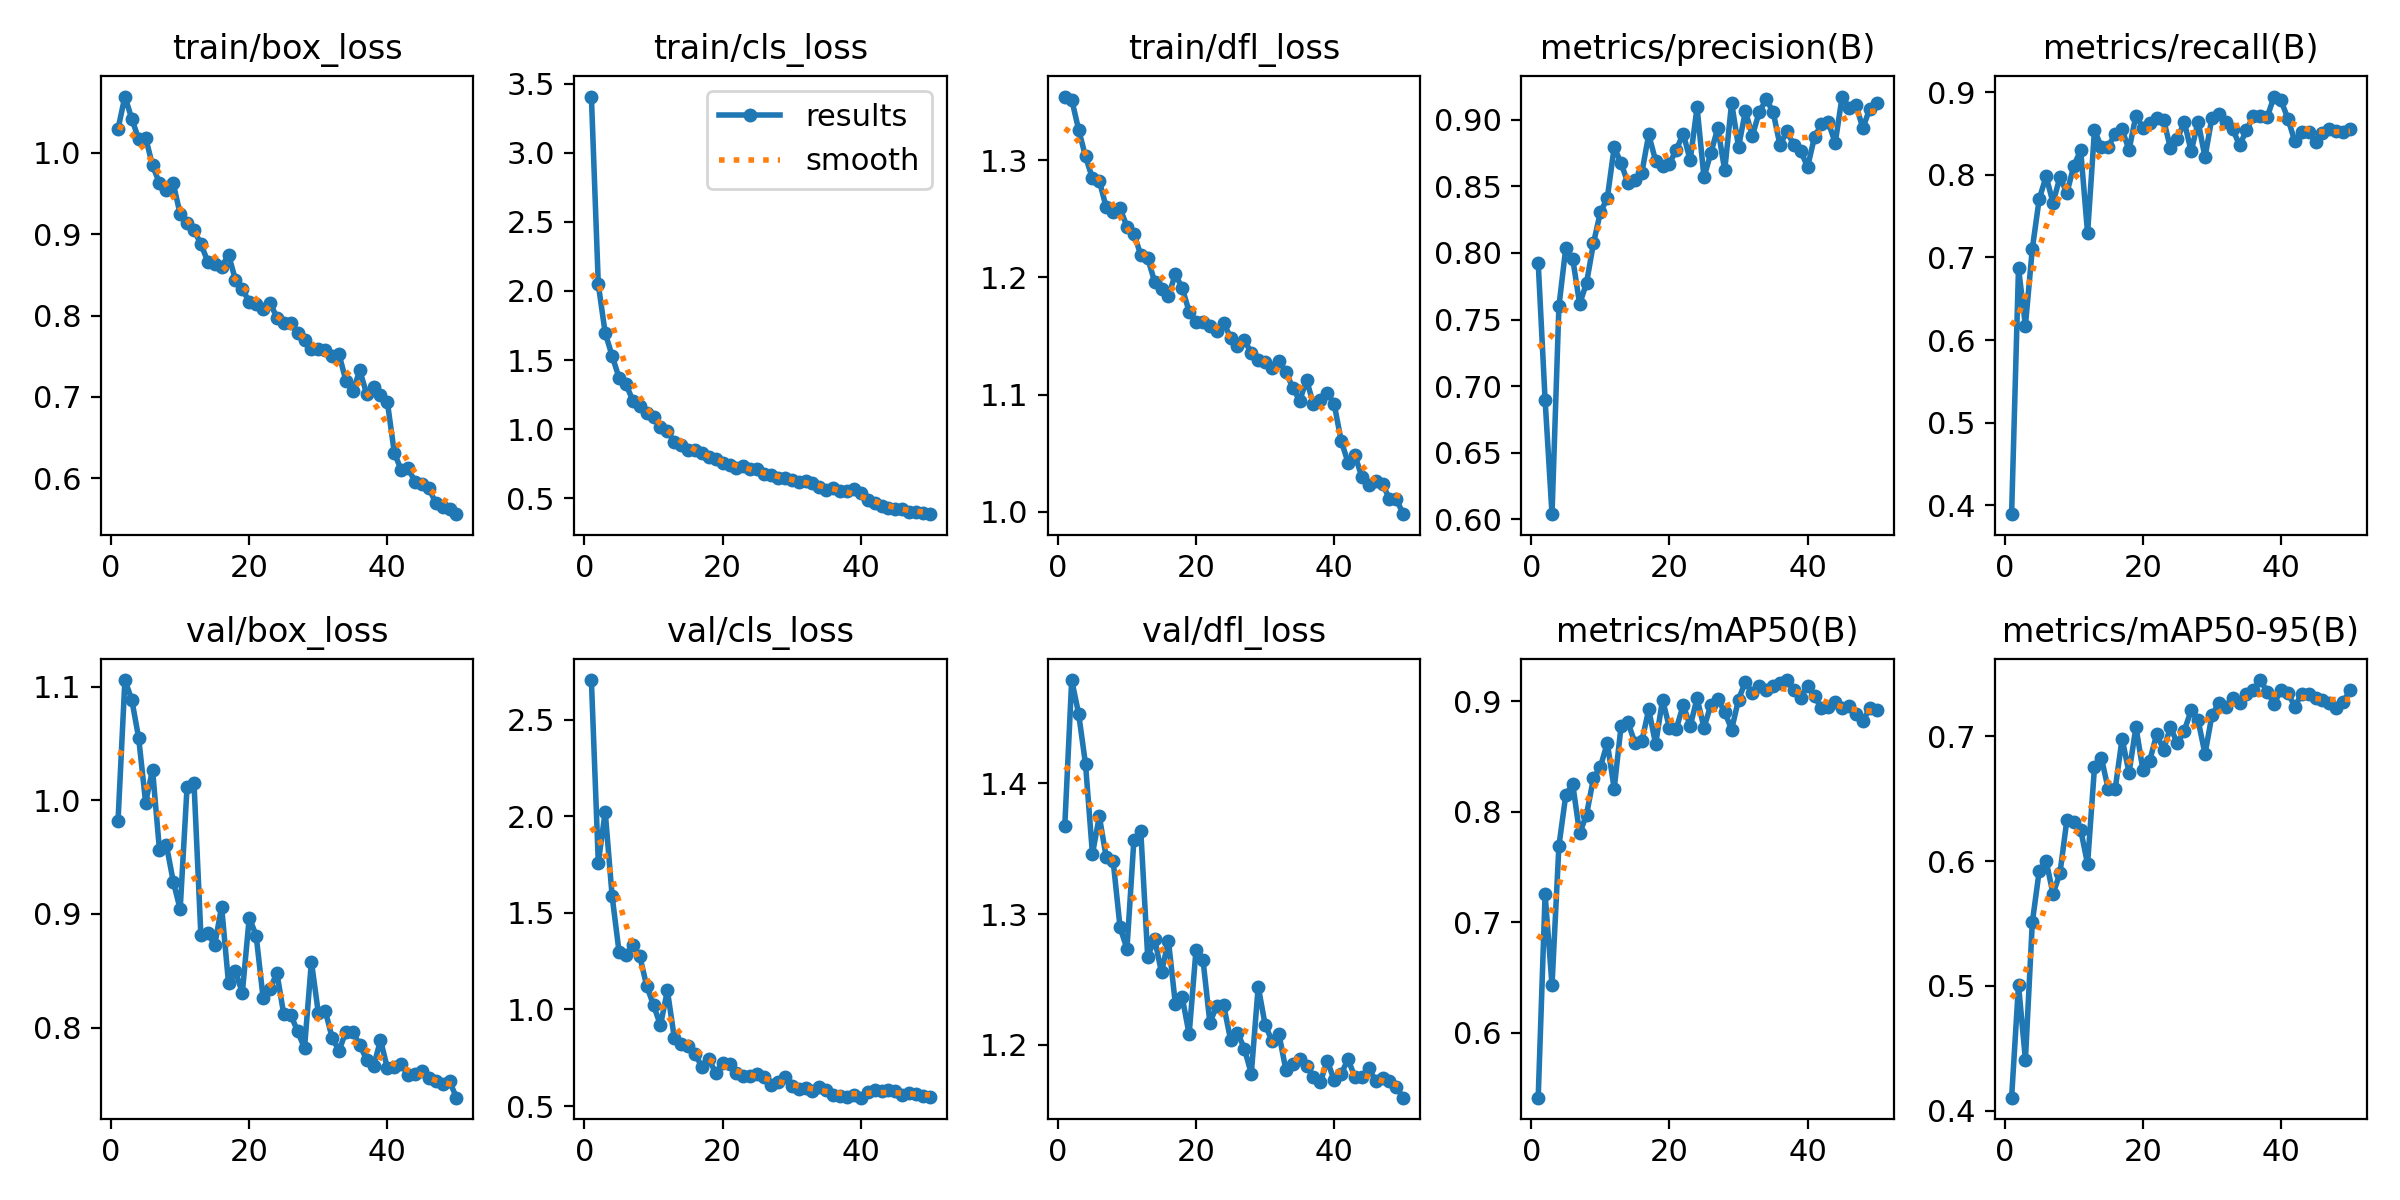

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,14.6288,1.02908,3.40605,1.35413,0.79277,0.38921,0.54117,0.41057,0.98152,2.70461,1.36771,0.000236,0.000236,0.000236
1,2,25.9125,1.06901,2.04718,1.35154,0.68952,0.68715,0.72520,0.50086,1.10606,1.75986,1.47899,0.000464,0.000464,0.000464
2,3,36.9779,1.04163,1.69427,1.32595,0.60377,0.61737,0.64304,0.44096,1.08869,2.02304,1.45333,0.000683,0.000683,0.000683
3,4,47.8723,1.01654,1.53077,1.30303,0.75992,0.71055,0.76896,0.55094,1.05471,1.58653,1.41477,0.000672,0.000672,0.000672
4,5,58.7861,1.01848,1.37161,1.28437,0.80406,0.77074,0.81516,0.59205,0.99810,1.29891,1.34609,0.000657,0.000657,0.000657


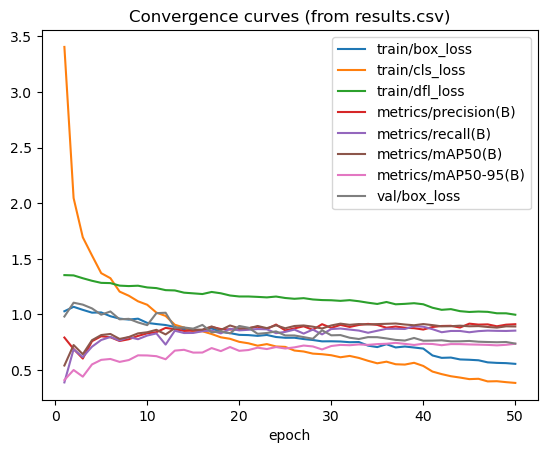

In [20]:
while True:
    status, _ = get_training_job_status(job_name)
    if status in ['Completed', 'Failed', 'Stopped']:
        print('Final status:', status)
        break
    time.sleep(20)

if status != 'Completed':
    raise RuntimeError(f'Training job not completed: {status}')

desc = sm.describe_training_job(TrainingJobName=job_name)
model_artifact = desc['ModelArtifacts']['S3ModelArtifacts']
print('Model artifact:', model_artifact)

out_dir = Path('artifacts') / job_name
out_dir.mkdir(parents=True, exist_ok=True)

S3Downloader.download(model_artifact, str(out_dir))
local_tar = out_dir / 'model.tar.gz'
print('Downloaded:', local_tar)

with tarfile.open(local_tar, 'r:gz') as t:
    t.extractall(path=out_dir)

best_pt = out_dir / 'best.pt'
results_png = out_dir / 'runs' / 'train' / 'results.png'
results_csv = out_dir / 'runs' / 'train' / 'results.csv'

print('best.pt exists:', best_pt.exists())
print('results.png exists:', results_png.exists())
print('results.csv exists:', results_csv.exists())

if results_png.exists():
    display(Image(filename=str(results_png)))

if results_csv.exists():
    df = pd.read_csv(results_csv)
    display(df.head())

    cols = [c for c in df.columns if c.lower() not in ['epoch', 'time']]
    x = df['epoch'] if 'epoch' in df.columns else range(len(df))

    to_plot = cols[:8]
    plt.figure()
    for c in to_plot:
        plt.plot(x, df[c], label=c)
    plt.xlabel('epoch')
    plt.legend()
    plt.title('Convergence curves (from results.csv)')
    plt.show()
else:
    print('找不到 results.csv；請確認 runs/ 是否有被寫入 /opt/ml/model/runs')


## 6) 視覺化推論（Visualized Inference）

- 會使用下載後的 `best.pt`
- 從你解壓後的資料夾中找幾張 `val` 影像做推論並顯示 bbox

> 注意：這格需要你先跑完第 5 格（已下載並解壓 artifacts）。

In [22]:
!pip install -U ultralytics opencv-python

Dataset extracted to: dataset_local

🔍 Searching for valid/images folder...
✅ Found: dataset_local/valid/images
✅ 找到 430 張 validation 影像

🎯 Using weights: artifacts/yolo11-train-1767602003/best.pt
📸 Visualizing 8 fruit images:
   - good_quality_753_jpg.rf.1aa3ad514ff5f078b86a9a0e6fe34256.jpg
   - banana5_018_jpg.rf.e44f99c648369c18a58d6849477354b6.jpg
   - watermalon165_jpg.rf.04d1d3d3bf742566d06343f6f597eec7.jpg
   - IMG_1063_jpeg_jpeg.rf.43853e3b00e65aa6e3a9fc4f569d1eaa.jpg
   - fresh-336-_png.rf.d0403f4faf311cd4a1683607ed688b1b.jpg
   - 10ffbbdd_jpg.rf.d7836e74d6bae2789eca98df8e0f6012.jpg
   - good_quality_961_jpg.rf.f2601d534cefd7675e05f2c0a5a790c0.jpg
   - 6_jpg.rf.70ed83cdb8f7fd61b73736badb238fe6.jpg

🖼️  Layout: 2x4 grid

📸 good_quality_753_jpg.rf.1aa3ad514ff5f078b86a9a0e6fe34256.jpg
   🍎 lemon: 93.25%

📸 banana5_018_jpg.rf.e44f99c648369c18a58d6849477354b6.jpg
   🍎 banana: 96.51%

📸 watermalon165_jpg.rf.04d1d3d3bf742566d06343f6f597eec7.jpg
   🍎 watermelon: 41.44%
   🍎 watermelon

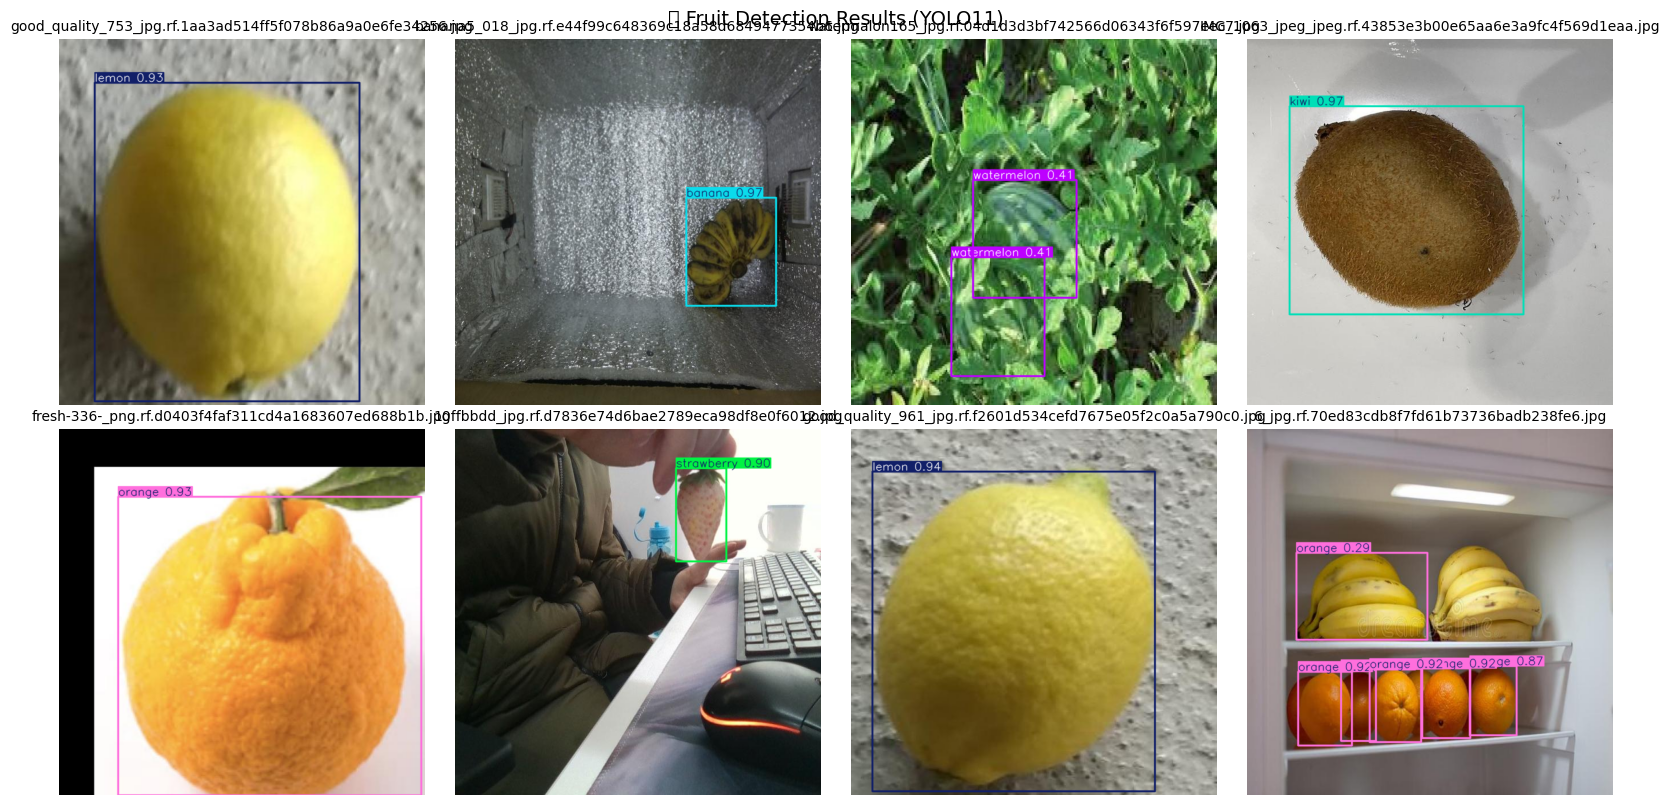


✅ 推論完成！共處理 8 張影像


In [25]:
from ultralytics import YOLO
from pathlib import Path
import random
import matplotlib.pyplot as plt
from PIL import Image as PILImage

# 下載並解壓 Fruit.v7i.yolov11 dataset（只需做一次）
from sagemaker.s3 import S3Downloader
from pathlib import Path
import zipfile

LOCAL_DATA_DIR = Path("dataset_local")
LOCAL_DATA_DIR.mkdir(exist_ok=True)

local_zip = LOCAL_DATA_DIR / DATA_ZIP_FILENAME

# 從 S3 下載 Fruit.v7i.yolov11 dataset zip
if not local_zip.exists():
    print(f"📥 Downloading {S3_DATA_ZIP}...")
    S3Downloader.download(S3_DATA_ZIP, str(LOCAL_DATA_DIR))
    print("✅ Download complete")

# 解壓
if not (LOCAL_DATA_DIR / "extracted").exists():
    print(f"📦 Extracting {local_zip}...")
    with zipfile.ZipFile(local_zip, "r") as z:
        z.extractall(LOCAL_DATA_DIR)
    (LOCAL_DATA_DIR / "extracted").touch()  # 標記已解壓
    print("✅ Extraction complete")

print("Dataset extracted to:", LOCAL_DATA_DIR)

# 🔍 自動搜尋 valid/images 資料夾
print("\n🔍 Searching for valid/images folder...")
VAL_IMAGES_DIR = None
for item in LOCAL_DATA_DIR.rglob("*"):
    if item.is_dir() and item.name == "images" and item.parent.name == "valid":
        VAL_IMAGES_DIR = item
        print(f"✅ Found: {VAL_IMAGES_DIR}")
        break

# 如果還是找不到，列出資料夾結構
if VAL_IMAGES_DIR is None or not VAL_IMAGES_DIR.exists():
    print("❌ Cannot find valid/images folder. Directory structure:")
    for item in sorted(LOCAL_DATA_DIR.rglob("*"))[:50]:  # 只顯示前 50 個
        indent = "  " * (len(item.relative_to(LOCAL_DATA_DIR).parts) - 1)
        marker = "📁" if item.is_dir() else "📄"
        print(f"{indent}{marker} {item.name}")
    
    raise FileNotFoundError(
        f"找不到 Fruit 資料集的 valid/images 路徑\n"
        f"請檢查上方列出的資料夾結構，並手動設定 VAL_IMAGES_DIR"
    )

# 推論權重（第 13 格解壓後應該存在）
weights = best_pt  # 由第 13 格定義：out_dir/best.pt
assert Path(weights).exists(), f"best.pt not found: {weights}"

candidates = []

# 從 Fruit 資料集 valid/images 找影像
candidates = list(VAL_IMAGES_DIR.glob("*.jpg")) + list(VAL_IMAGES_DIR.glob("*.png"))
print(f"✅ 找到 {len(candidates)} 張 validation 影像")

if not candidates:
    raise FileNotFoundError(f"valid/images 資料夾中沒有影像檔案: {VAL_IMAGES_DIR}")

# 抽樣 8 張水果影像進行視覺化
k = min(8, len(candidates))
sample_imgs = random.sample(candidates, k=k)
print(f"\n🎯 Using weights: {weights}")
print(f"📸 Visualizing {k} fruit images:")
for p in sample_imgs:
    print(f"   - {p.name}")

model = YOLO(str(weights))

# 🎨 根據影像數量動態調整布局
if k <= 2:
    rows, cols = 1, k
elif k <= 4:
    rows, cols = 2, 2
elif k <= 6:
    rows, cols = 2, 3
else:
    rows, cols = 2, 4

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

# 確保 axes 是陣列（即使只有一個子圖）
if k == 1:
    axes = [axes]
else:
    axes = axes.flatten() if hasattr(axes, 'flatten') else axes

print(f"\n🖼️  Layout: {rows}x{cols} grid")

# 逐張推論並顯示（水果檢測結果）
for idx, img_path in enumerate(sample_imgs):
    results = model.predict(source=str(img_path), imgsz=IMGSZ, conf=0.25, verbose=False)
    r = results[0]
    
    # 輸出檢測資訊
    print(f"\n📸 {Path(img_path).name}")
    if r.boxes is not None and len(r.boxes) > 0:
        for box_idx, (cls, conf) in enumerate(zip(r.boxes.cls.cpu().numpy(), r.boxes.conf.cpu().numpy())):
            class_name = CLASS_NAMES[int(cls)]
            print(f"   🍎 {class_name}: {conf:.2%}")
    else:
        print("   ❌ No fruits detected")
    
    # 繪製結果
    plotted = r.plot()  # numpy array (BGR)
    plotted_rgb = plotted[..., ::-1]  # BGR -> RGB
    
    axes[idx].imshow(plotted_rgb)
    axes[idx].axis("off")
    axes[idx].set_title(f"{Path(img_path).name}", fontsize=10)

# 隱藏多餘的子圖
for idx in range(k, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.suptitle("🍎 Fruit Detection Results (YOLO11)", fontsize=14, y=1.00)
plt.show()

print(f"\n✅ 推論完成！共處理 {k} 張影像")